# Experimenting with SpecletNine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from time import time
from typing import Any, Callable, Optional

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.io.cache_io import temp_dir
from src.loggers import set_console_handler_level
from src.models.speclet_nine import (
    SpecletNine,
    SpecletNineConfiguration,
    make_speclet_nine_priors_config,
)
from src.plot.plotnine_helpers import set_gg_theme
from src.project_config import read_project_configuration

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARNING)

set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

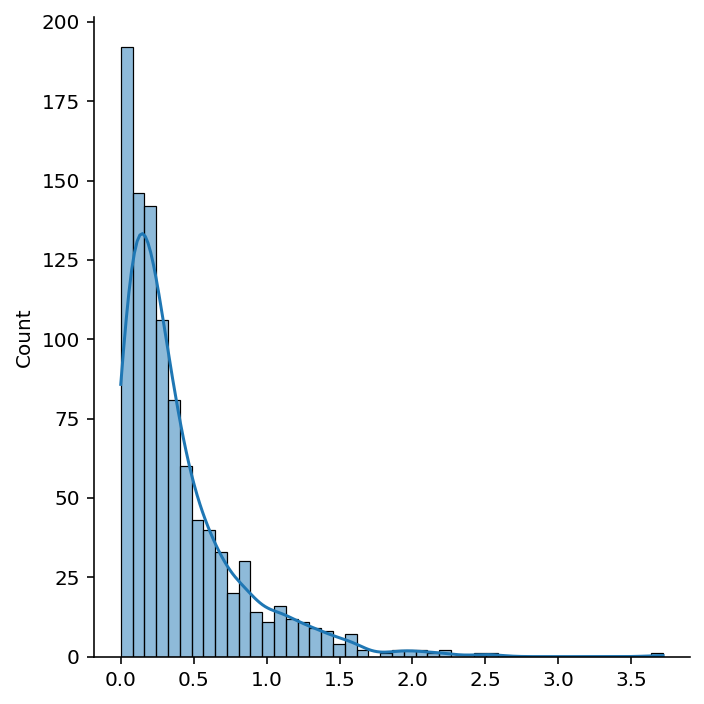

In [5]:
with pm.Model():
    # x = pm.Gamma(name="x", alpha=1, beta=0.7).random(size=1000)
    x = pm.Exponential("x", 2.5).random(size=1000)

sns.displot(x=x, kind="hist", kde=True)

[11/08/21 09:30:34] WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=279361;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

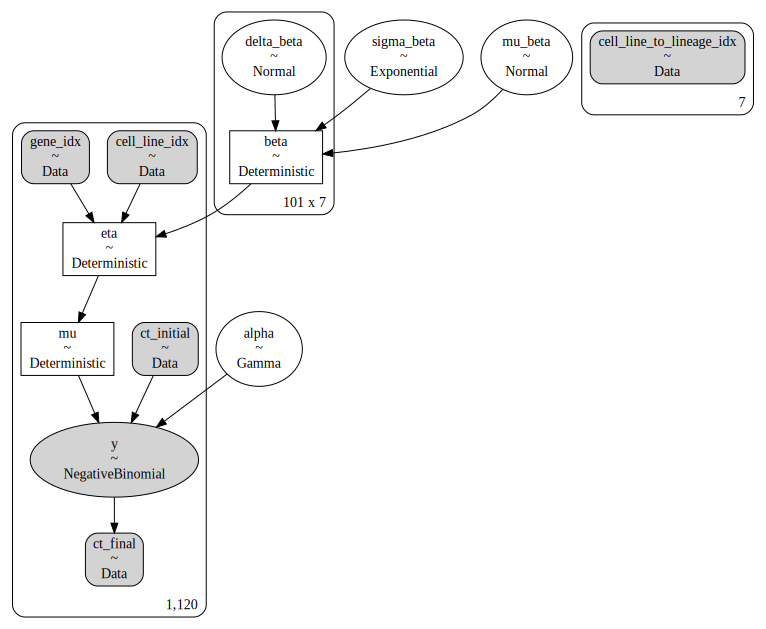

In [6]:
# config = make_speclet_nine_priors_config(
#     mu_mu_beta_mu=0.0,
#     mu_mu_beta_sigma=1.0,
#     sigma_mu_beta_sigma=1.0,
#     sigma_beta_alpha=1.0,
#     sigma_beta_beta=5.0,
#     alpha_alpha=2.0,
#     alpha_beta=0.3,
# )
config = SpecletNineConfiguration()
sp9 = SpecletNine("sp9-expr", root_cache_dir=temp_dir(), config=config)
# sp9 = SpecletNine("sp9-expr", root_cache_dir=temp_dir())
sp9.build_model()
assert sp9.model is not None
pm.model_to_graphviz(sp9.model)

In [7]:
data = sp9.data_manager.get_data()
# ct_i = np.abs(np.random.normal(loc=100, scale=5, size=data.shape[0])) + 1
# # ct_i = np.ones(data.shape[0])
# ct_f = np.abs(ct_i + np.random.normal(loc=0, scale=10, size=data.shape[0]))
# data["counts_initial_adj"] = ct_i.astype(np.int64)
# data["counts_final"] = ct_f.astype(np.int64)
# sp9.data_manager.set_data(data, apply_transformations=False)

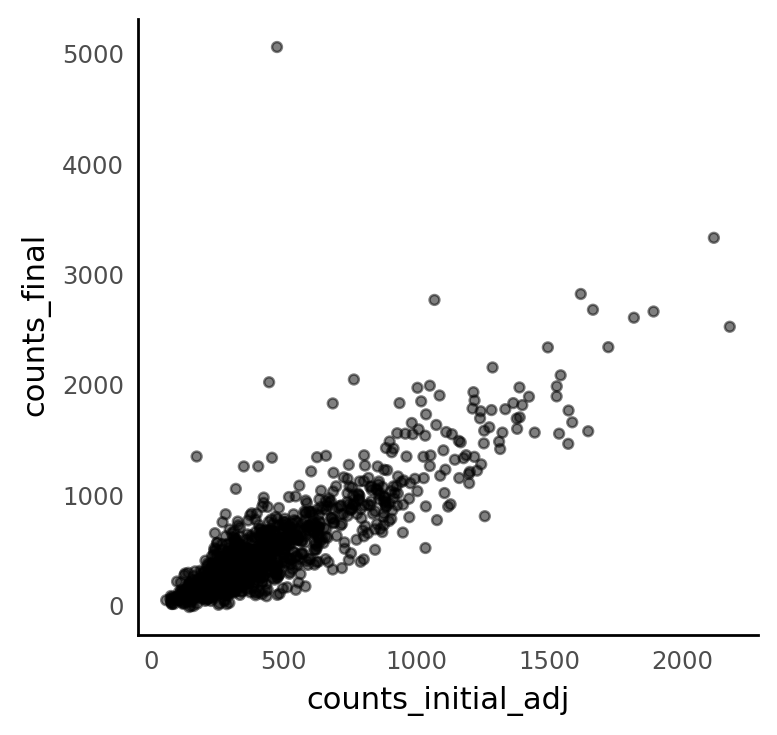

<ggplot: (362348457)>

In [8]:
(
    gg.ggplot(
        data.astype({"counts_initial_adj": float, "counts_final": float}),
        gg.aes(x="counts_initial_adj", y="counts_final"),
    )
    + gg.geom_point(alpha=0.5)
)

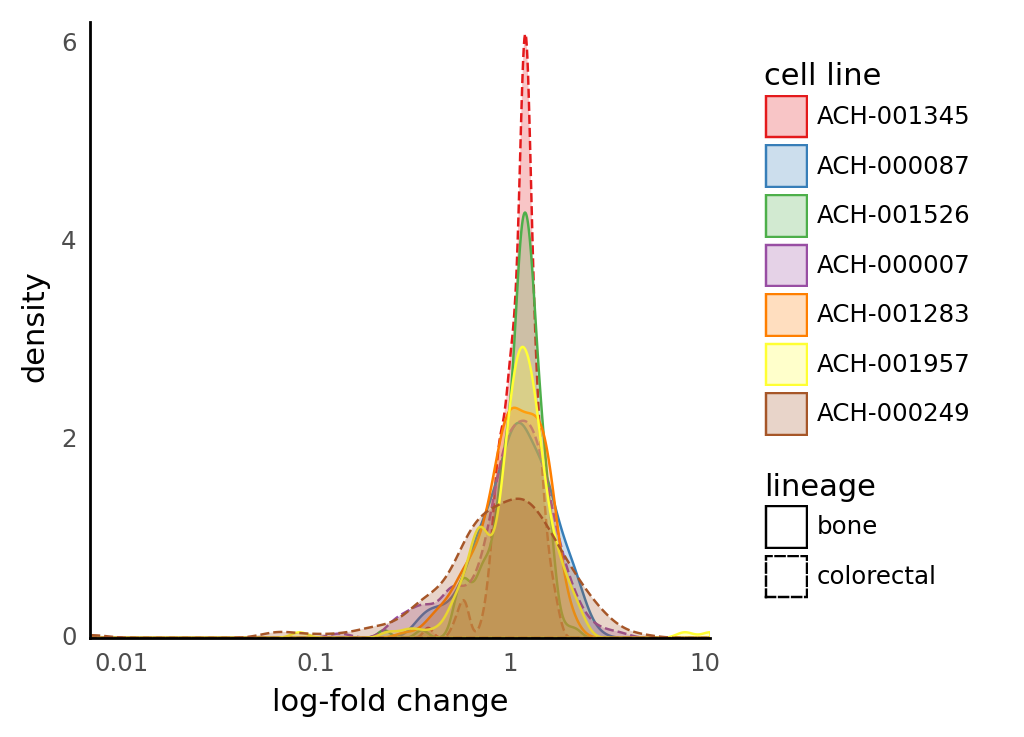

<ggplot: (363103229)>

In [9]:
(
    gg.ggplot(data, gg.aes(x="(counts_final + 1) / counts_initial_adj"))
    + gg.geom_density(
        gg.aes(color="depmap_id", fill="depmap_id", linetype="lineage"), alpha=0.25
    )
    + gg.scale_x_log10(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="log-fold change",
        y="density",
        color="cell line",
        fill="cell line",
        linetype="lineage",
    )
)

In [10]:
assert sp9.model is not None
with sp9.model:
    sp9_prior_pred = pm.sample_prior_predictive(random_seed=1234)

In [11]:
def plot_prior_pred(prior_samples: np.ndarray, scales: str = "fixed") -> gg.ggplot:
    """Plot prior predictive samples

    Args:
        prior_samples ([type]): Prior samples array with shape [samples, draws].

    Returns:
        gg.ggplot: A nice lil' plot for you and your buds.
    """
    prior_pred_df = (
        pd.DataFrame(prior_samples.T)
        .pivot_longer(names_to="prior_pred_sample", values_to="draw")
        .astype({"prior_pred_sample": "str"})
    )
    return (
        gg.ggplot(prior_pred_df, gg.aes(x="draw", fill="prior_pred_sample"))
        + gg.facet_wrap("prior_pred_sample", scales=scales)
        + gg.geom_histogram(bins=50, alpha=0.5, position="identity")
        + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(figure_size=(8, 6), legend_position="none")
    )

In [12]:
for p in ("mu_mu_beta", "sigma_mu_beta"):
    ax = sns.displot(sp9_prior_pred[p], kind="hist")
    ax.axes.flatten()[0].set_title(p)
    plt.show()

KeyError: 'mu_mu_beta'

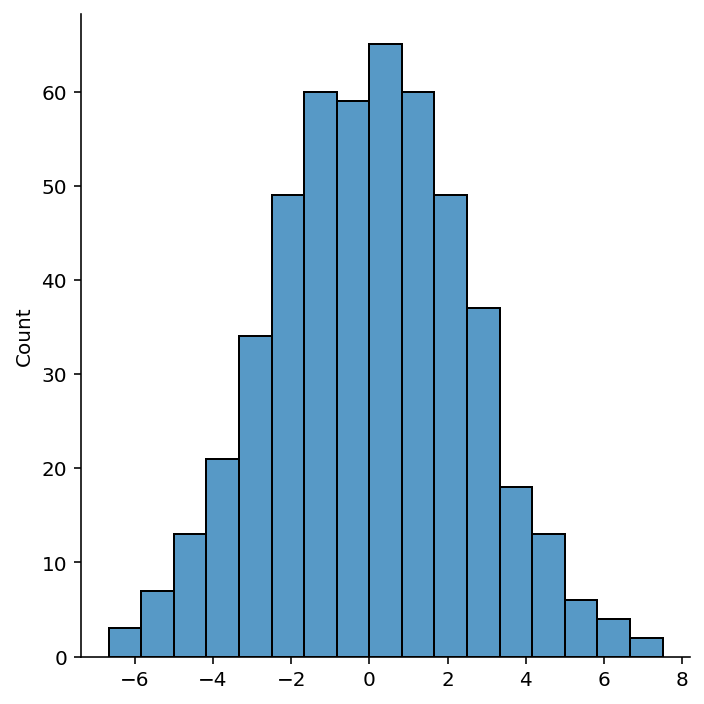

In [14]:
# plot_prior_pred(sp9_prior_pred["mu_beta"][:6, :].reshape(6, -1))
sns.displot(sp9_prior_pred["mu_beta"], kind="hist")
# plt.show()

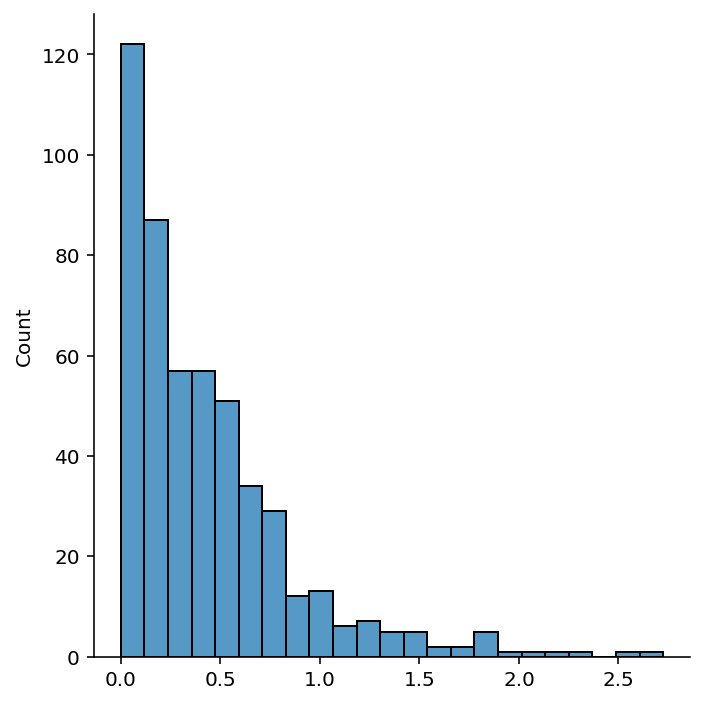

In [15]:
sns.displot(sp9_prior_pred["sigma_beta"], kind="hist")
plt.show()
# plot_prior_pred(sp9_prior_pred["sigma_beta"][:6, :, :].reshape(6, -1))

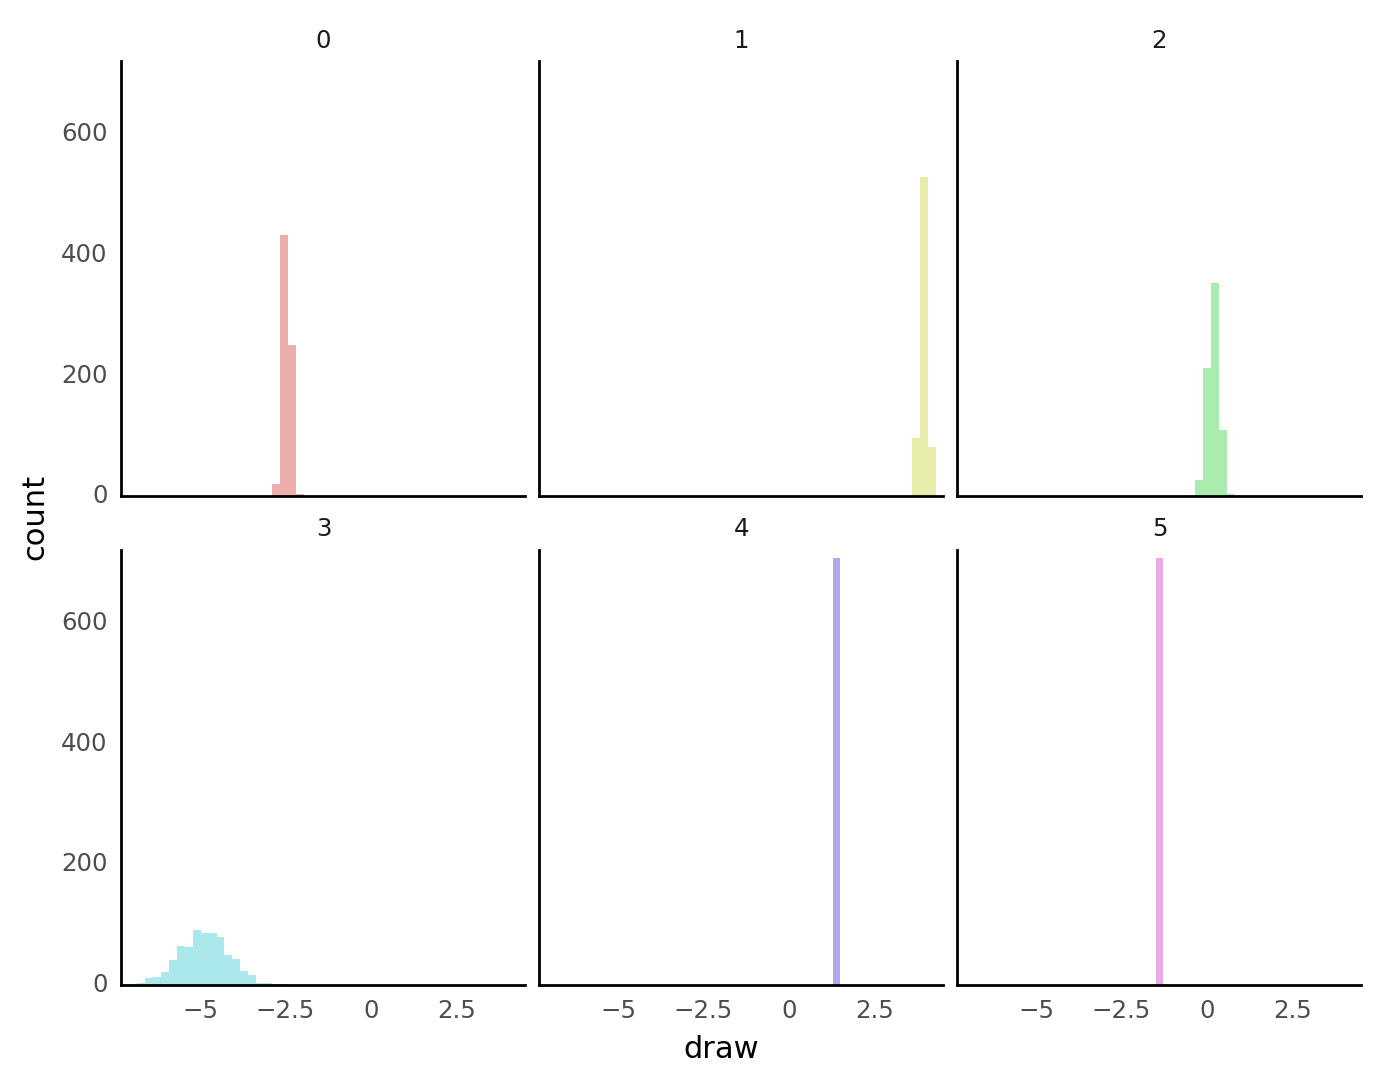

<ggplot: (363399677)>

In [16]:
plot_prior_pred(sp9_prior_pred["beta"][:6, :, :].reshape(6, -1))

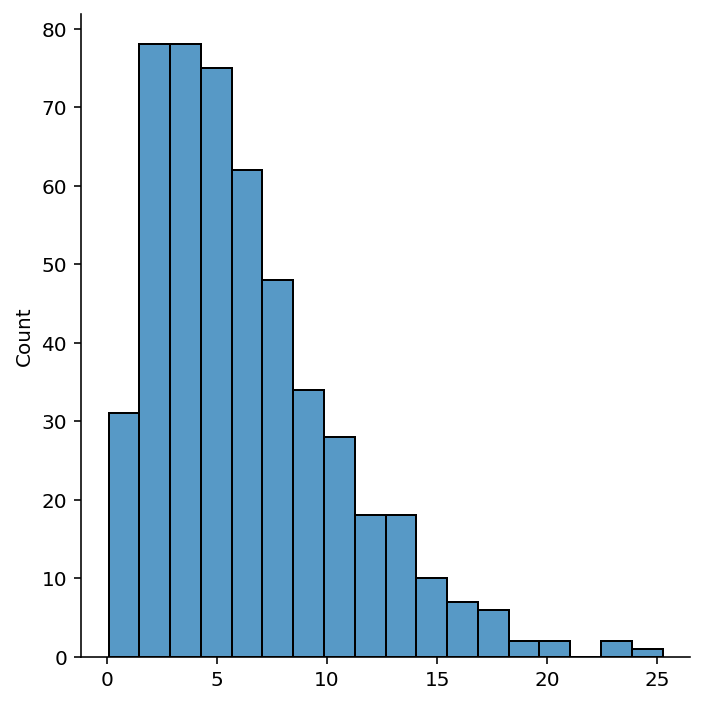

In [17]:
sns.displot(sp9_prior_pred["alpha"], kind="hist")
plt.show()

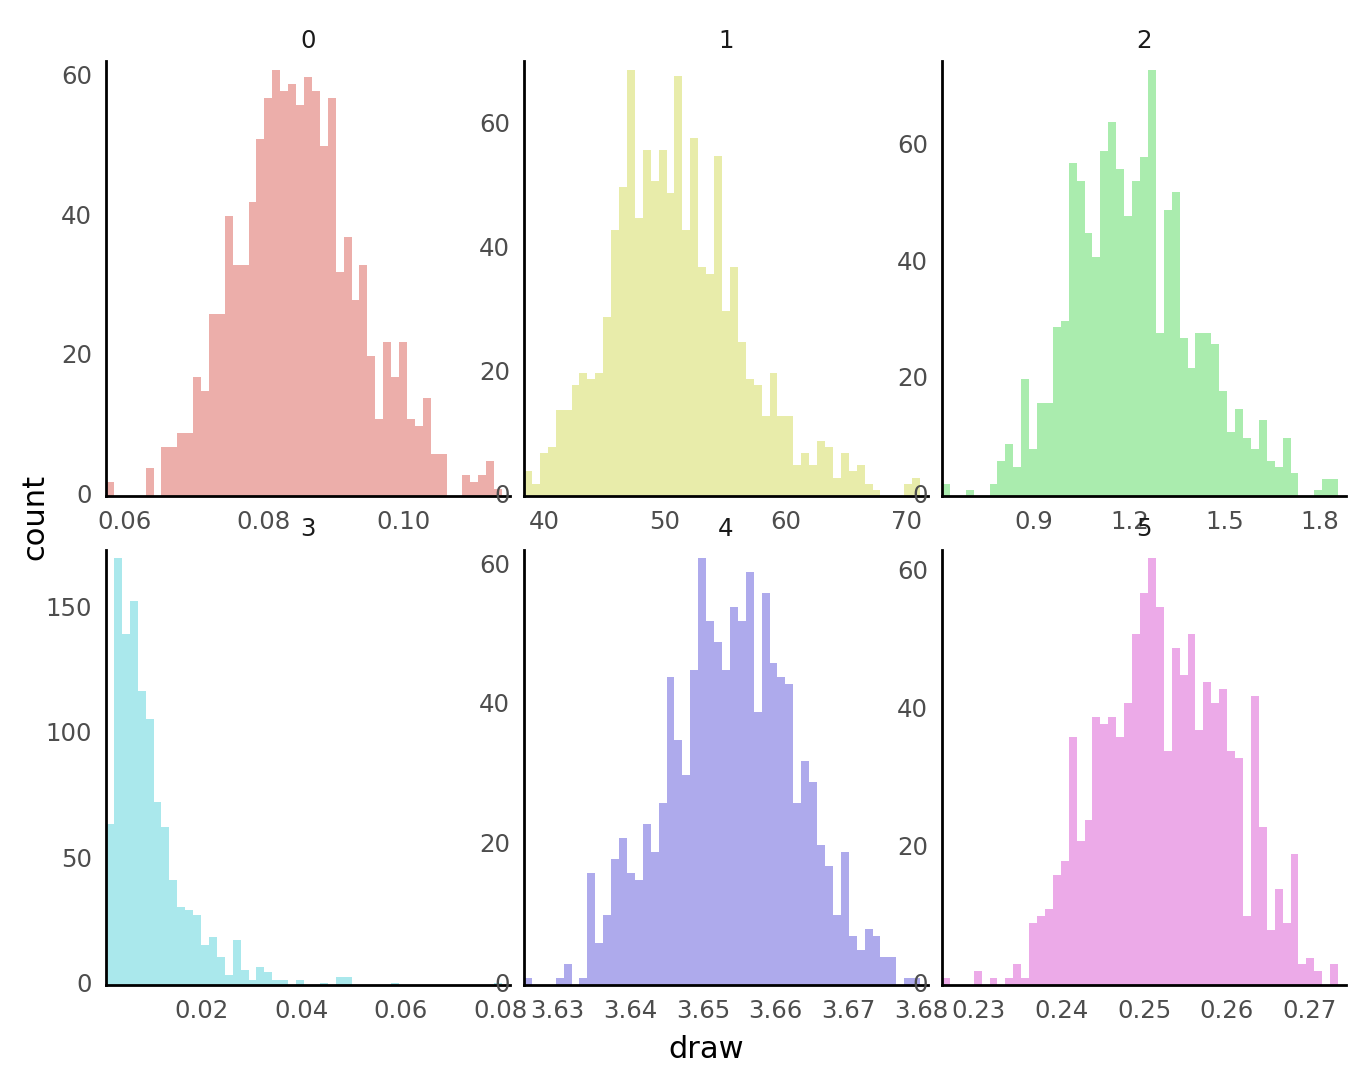

<ggplot: (362255620)>

In [18]:
plot_prior_pred(sp9_prior_pred["mu"][:6, :], scales="free")

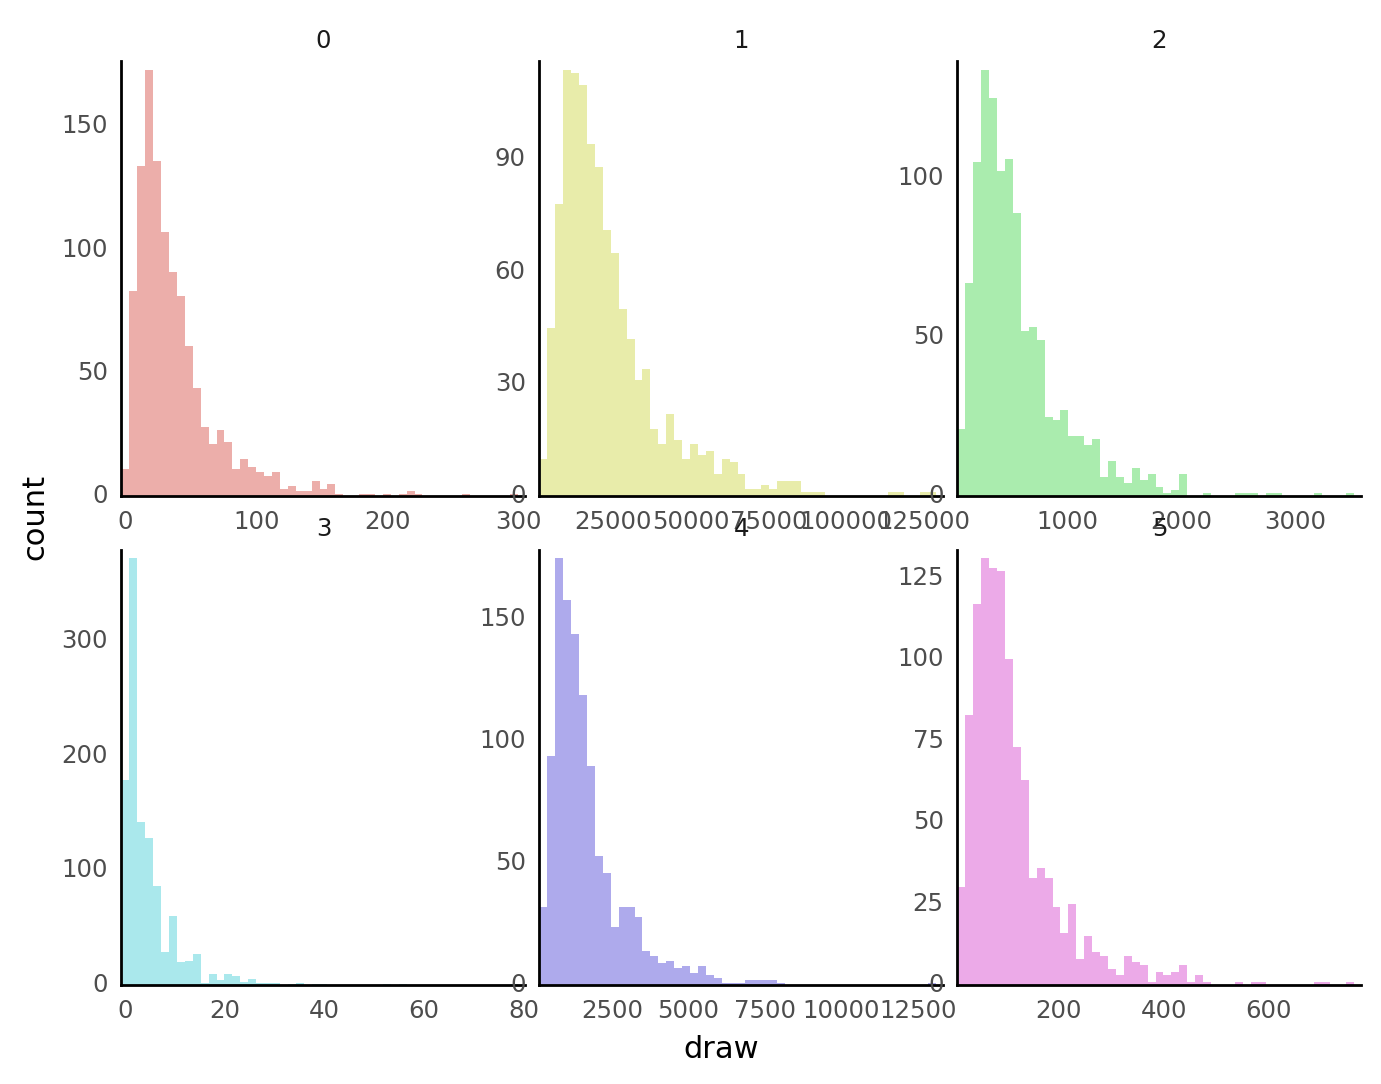

<ggplot: (363811566)>

In [19]:
(plot_prior_pred(sp9_prior_pred["y"][:6, :], scales="free"))

In [20]:
sp9_prior_pred["alpha"][:6]

array([ 4.82111046, 11.5503703 , 14.99850984,  5.04033985, 15.31636254,
        9.23039367])

In [21]:
sp9_prior_pred["mu"].mean(axis=1)[:6]

array([8.51252558e-02, 5.10481006e+01, 1.21673767e+00, 9.76900348e-03,
       3.65392463e+00, 2.52556605e-01])

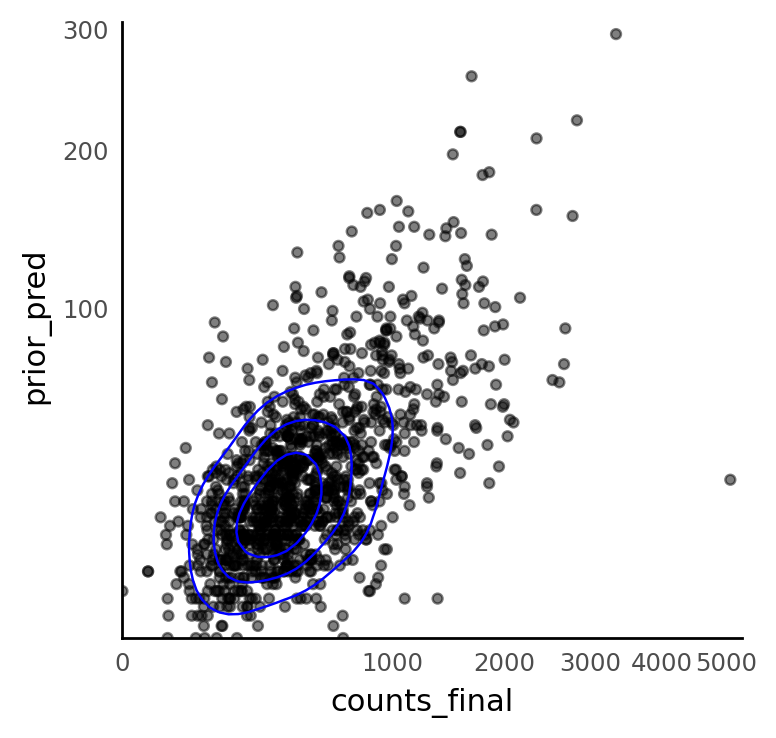

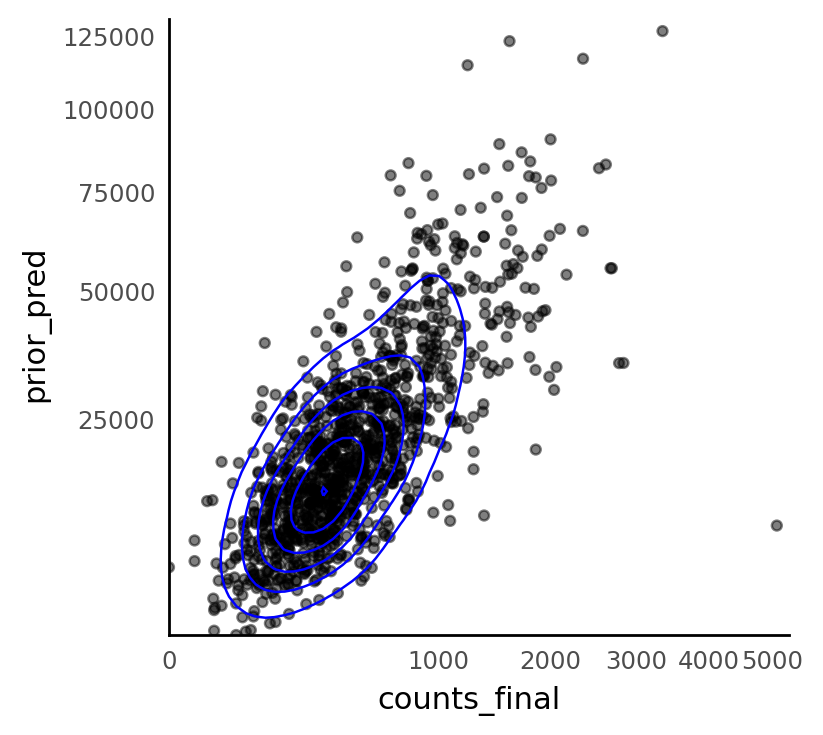

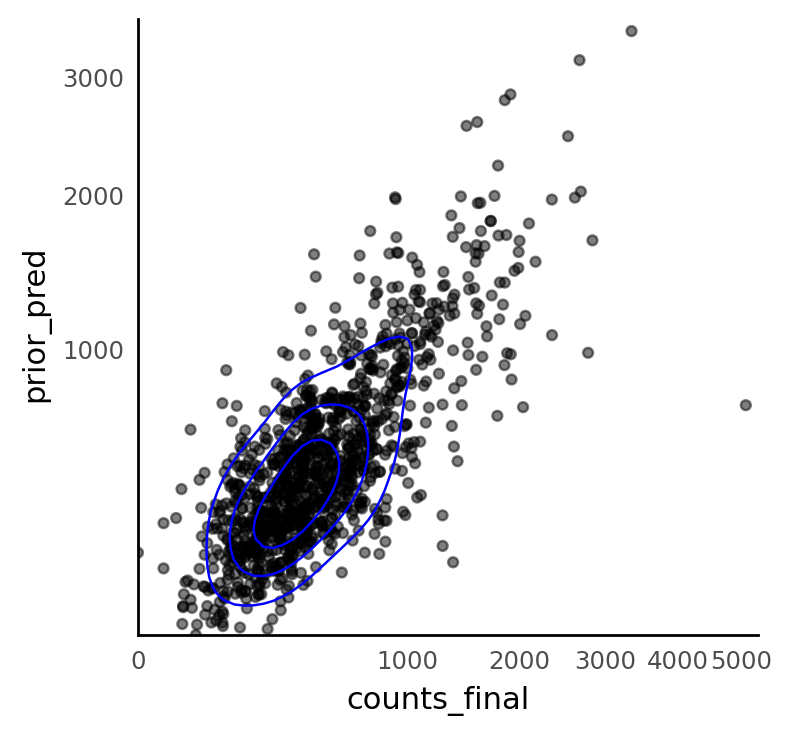

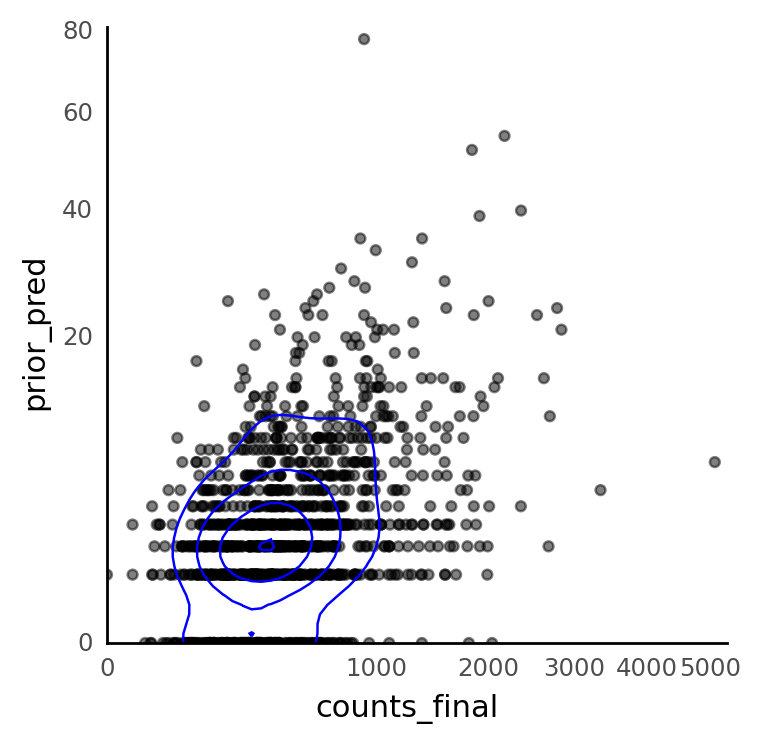

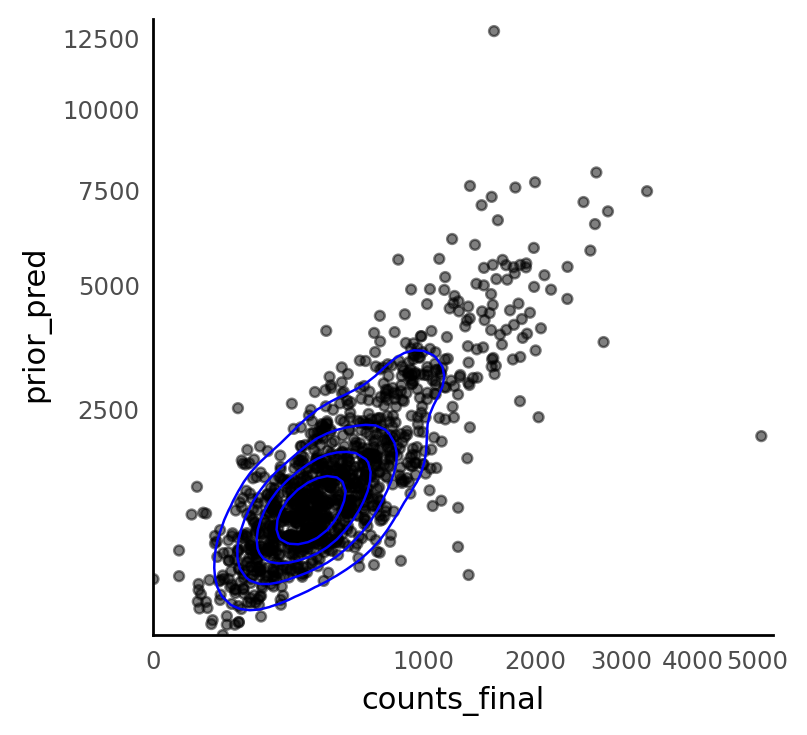

In [22]:
for i in range(5):
    y_prior_pred = (
        data.copy()
        .assign(prior_pred=sp9_prior_pred["y"][i, :])
        .astype({"counts_final": int})
    )
    print(
        gg.ggplot(y_prior_pred, gg.aes(x="counts_final", y="prior_pred"))
        + gg.geom_point(alpha=0.5)
        + gg.geom_density_2d(color="blue")
        + gg.scale_x_sqrt(expand=(0, 0, 0.02, 0))
        + gg.scale_y_sqrt(expand=(0, 0, 0.02, 0))
    )

In [23]:
def plot_prior_summary(
    prior_pred: np.ndarray, real_values: pd.Series, fxn: Callable
) -> gg.ggplot:
    prior_pred_means = fxn(prior_pred, axis=1)

    return (
        gg.ggplot(pd.DataFrame({"x": prior_pred_means}), gg.aes(x="x"))
        + gg.geom_histogram(bins=30)
        + gg.geom_vline(xintercept=fxn(real_values), color="blue")
        + gg.scale_x_log10(expand=(0, 0, 0.02, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    )

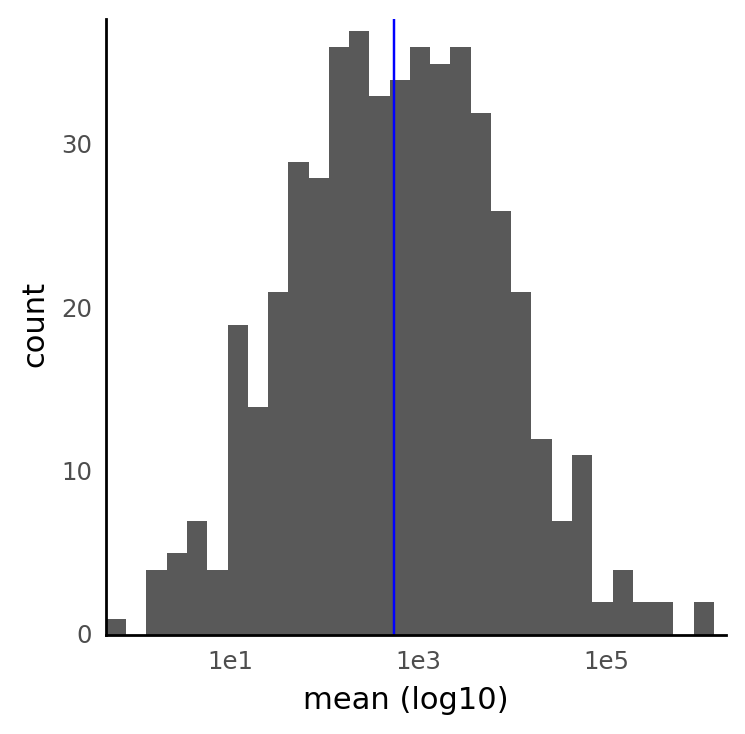

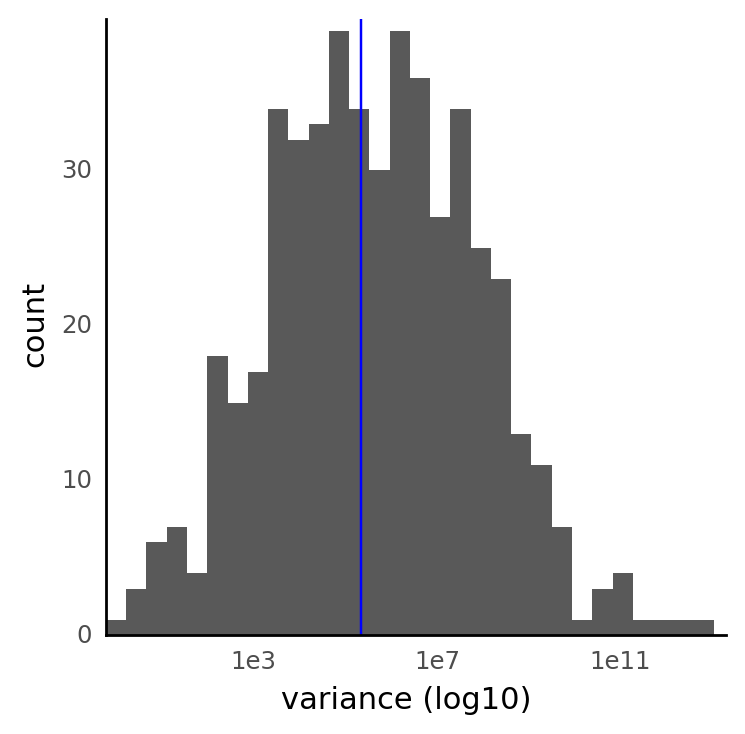

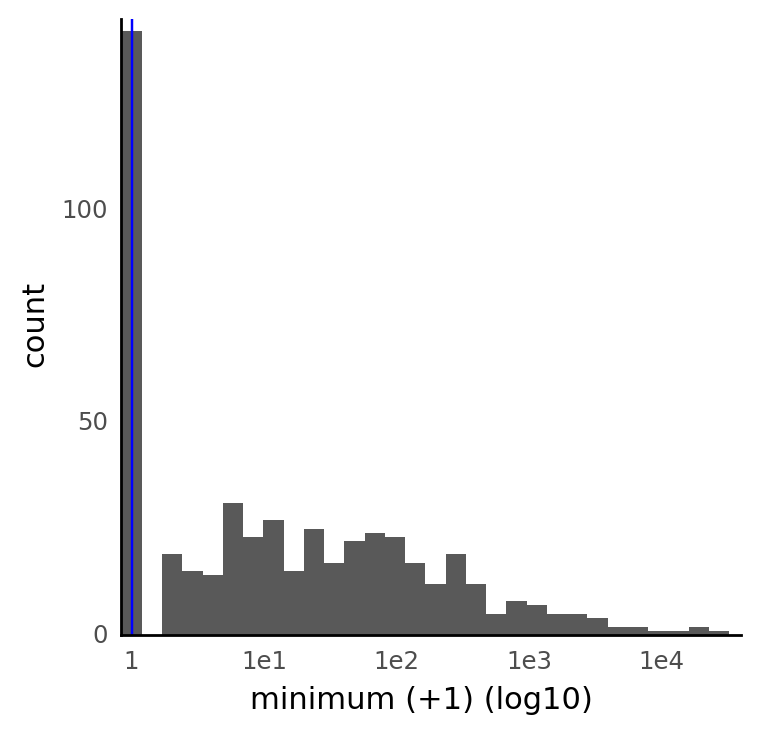

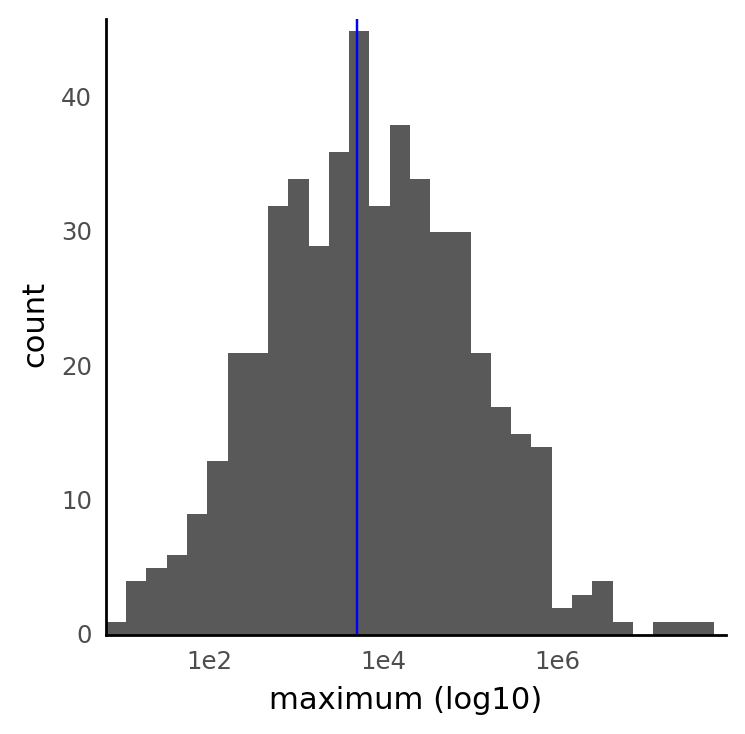

In [24]:
def min_p1(*args: Any, **kwargs: dict[str, Any]) -> Any:
    return np.min(*args, **kwargs) + 1


summary_stats: dict[str, Callable] = {
    "mean": np.mean,
    "variance": np.var,
    "minimum (+1)": min_p1,
    "maximum": np.max,
}

for name, fxn in summary_stats.items():
    p = plot_prior_summary(sp9_prior_pred["y"], data.counts_final, fxn) + gg.labs(
        x=f"{name} (log10)"
    )
    print(p)

---

In [25]:
sp9_mcmc = sp9.mcmc_sample_model(
    prior_pred_samples=None, random_seed=RANDOM_SEED, ignore_cache=True
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, delta_beta, sigma_beta, mu_beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
sp9_var_names = [
    # "mu_mu_beta",
    # "sigma_mu_beta",
    "mu_beta",
    "sigma_beta",
    "beta",
    "alpha",
]

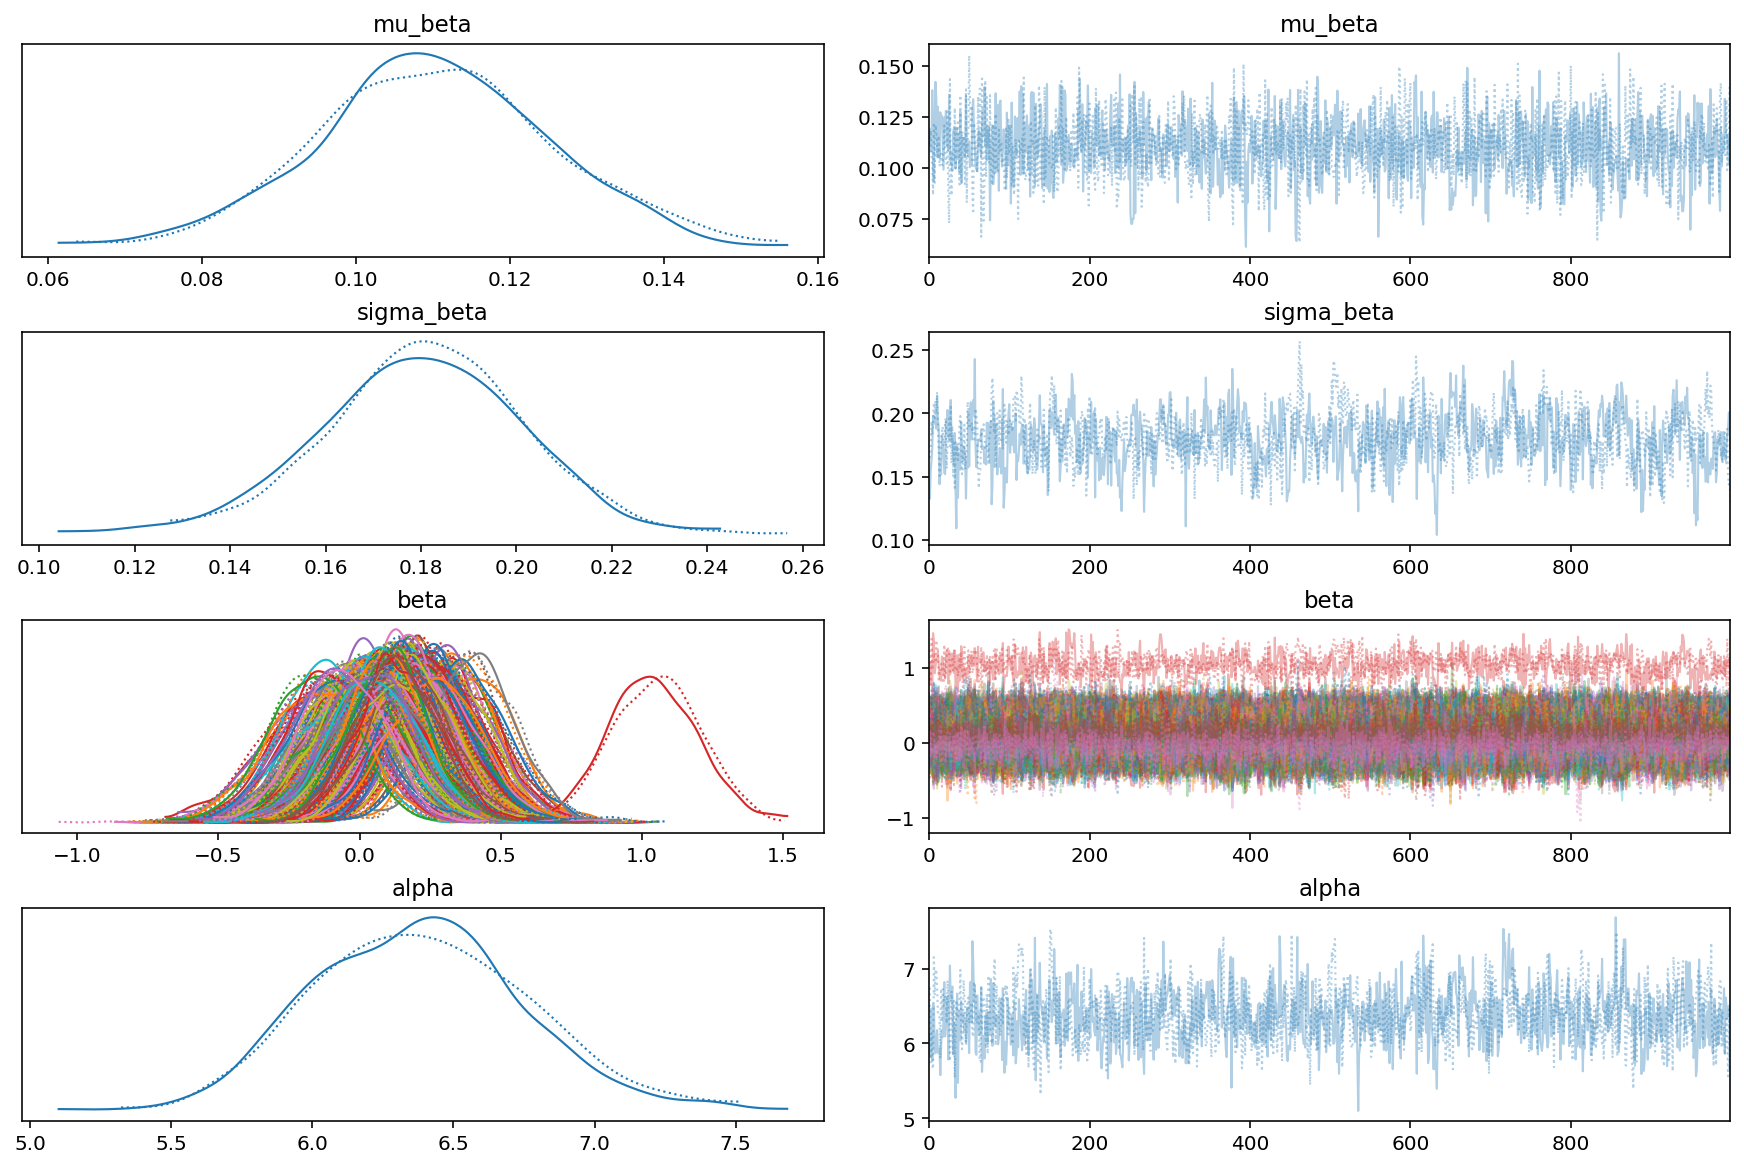

In [27]:
az.plot_trace(sp9_mcmc, var_names=sp9_var_names)
plt.show()

In [28]:
(
    az.summary(sp9_mcmc, var_names=sp9_var_names, hdi_prob=HDI_PROB)
    .sort_values("r_hat", ascending=False)
    .head()
)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[39,3]  0.095  0.168    -0.169      0.358      0.003    0.003    2846.0   
beta[29,0]  0.215  0.143    -0.026      0.431      0.003    0.003    2741.0   
beta[13,6]  0.279  0.148     0.059      0.538      0.003    0.003    2105.0   
beta[14,0]  0.091  0.149    -0.124      0.338      0.003    0.003    2628.0   
beta[58,1]  0.099  0.164    -0.151      0.359      0.003    0.003    3102.0   

            ess_tail  r_hat  
beta[39,3]    1238.0   1.01  
beta[29,0]     775.0   1.01  
beta[13,6]     903.0   1.01  
beta[14,0]     964.0   1.01  
beta[58,1]    1432.0   1.01

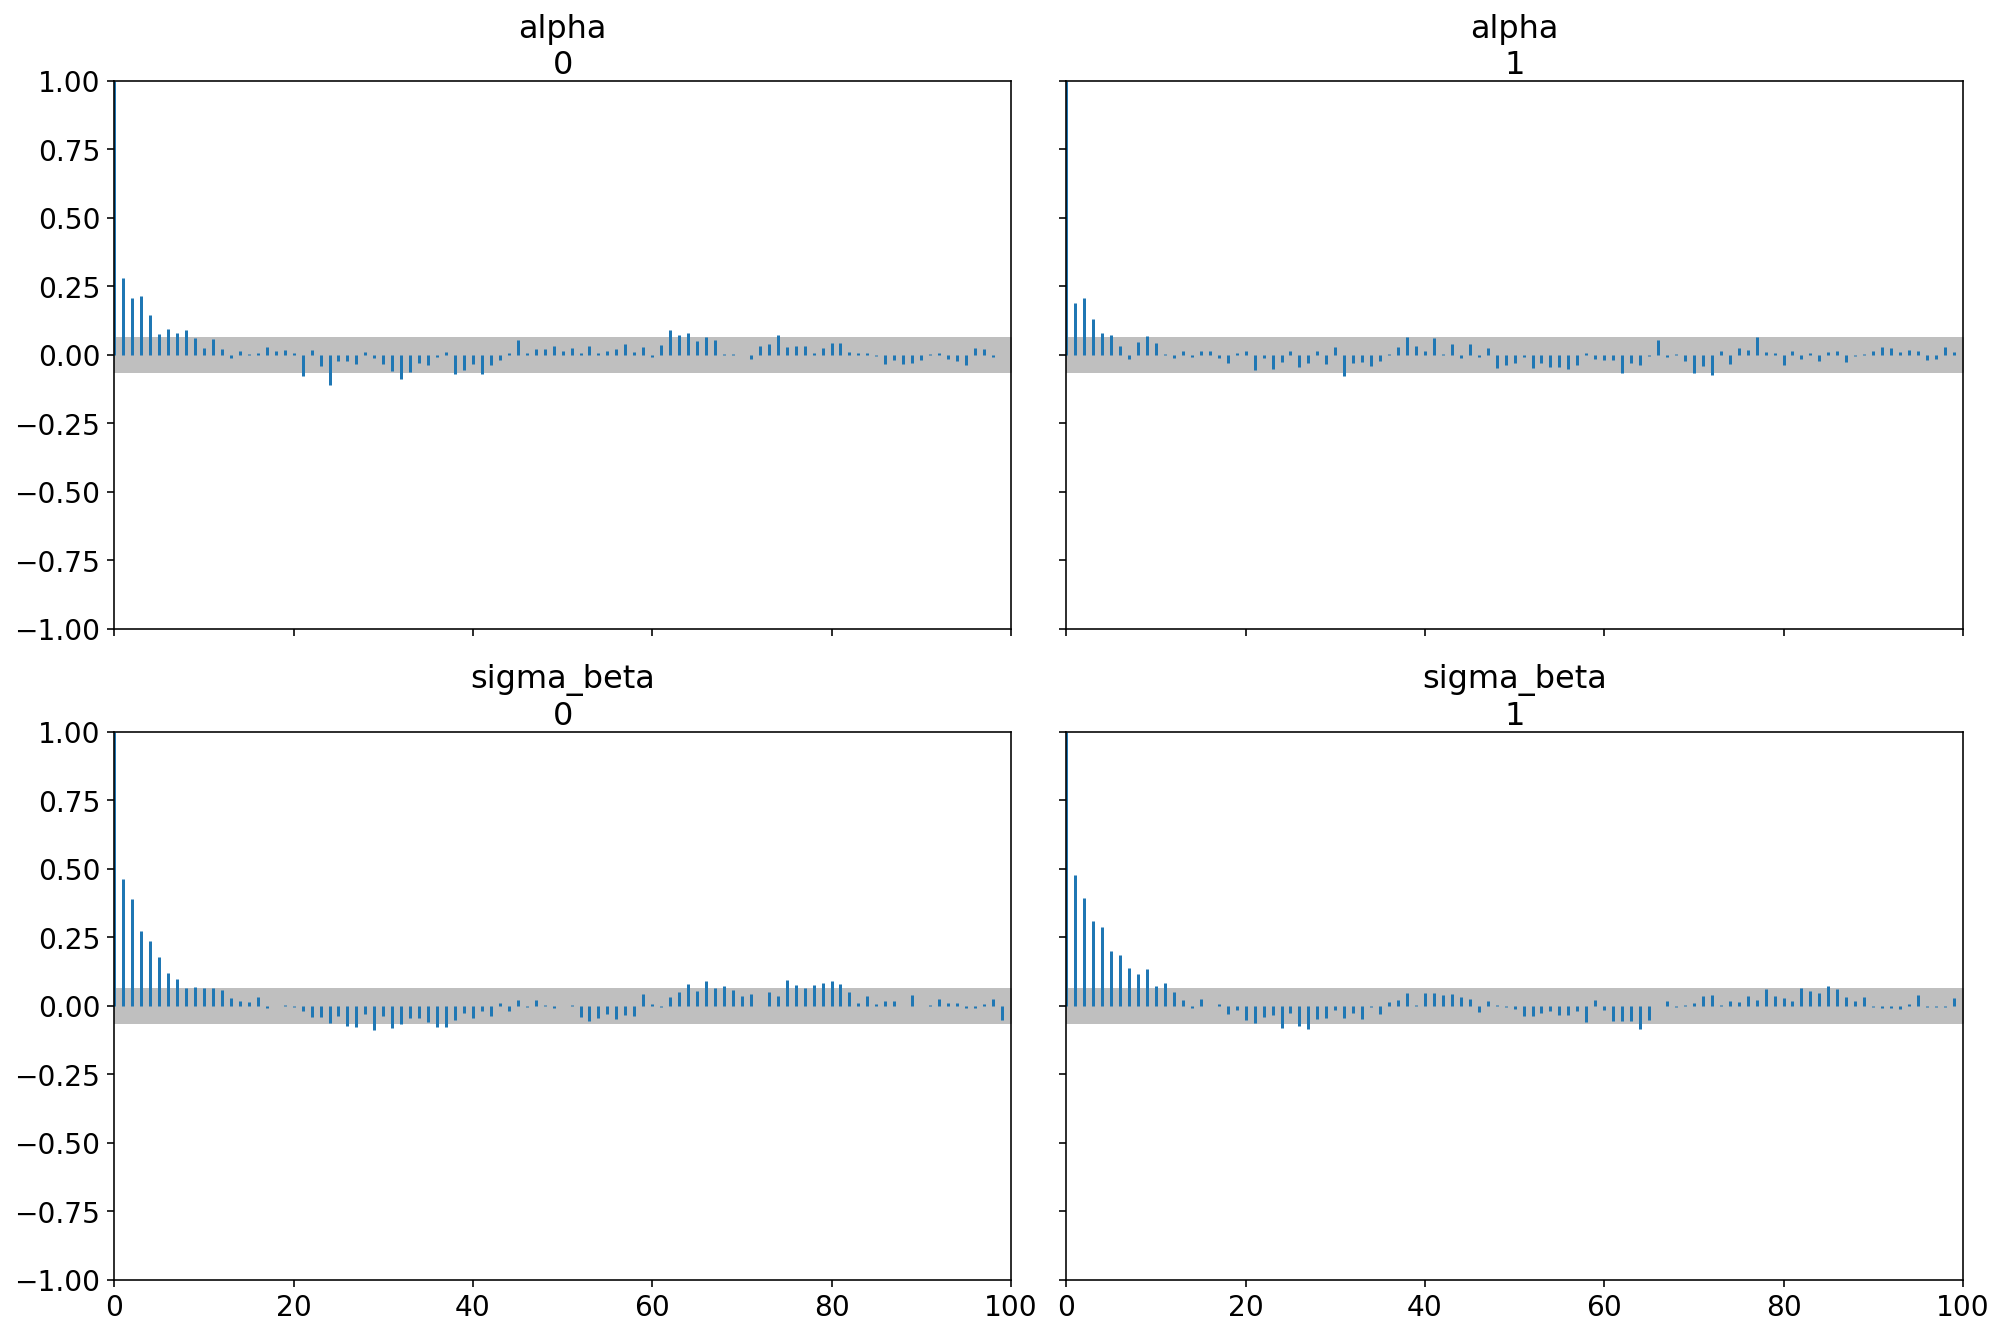

In [29]:
az.plot_autocorr(sp9_mcmc, var_names=["alpha", "sigma_beta"], grid=(2, 2))
plt.show()

In [ ]:
data[["lineage", "hugo_symbol"]].head()

lineage hugo_symbol
0  colorectal      TENT5B
1  colorectal      TENT5B
2  colorectal       USP46
3  colorectal      ALKBH8
4  colorectal        ING5

TypeError: 'AxesSubplot' object is not subscriptable

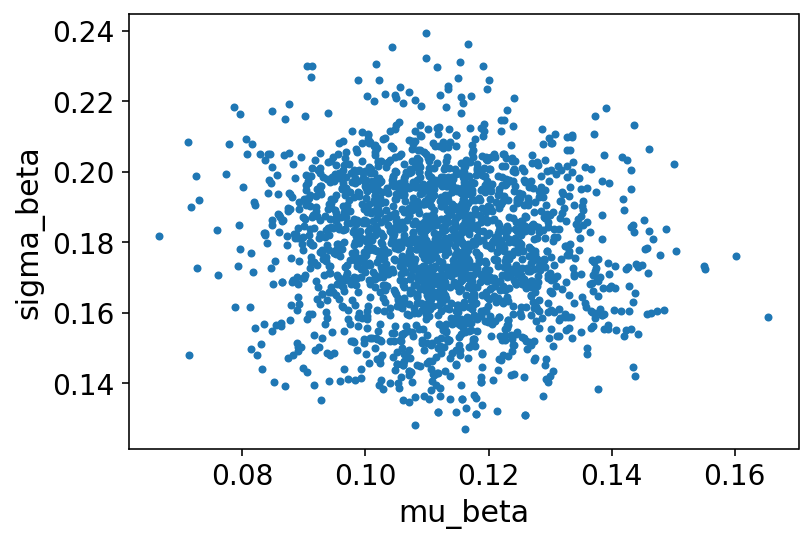

In [28]:
axes = az.plot_pair(
    sp9_mcmc,
    var_names=["mu_beta", "sigma_beta"],
    coords={"gene": "KRAS"},
    divergences=True,
)
for ax in axes[1, :]:
    ax.set_yscale("log")
plt.show()

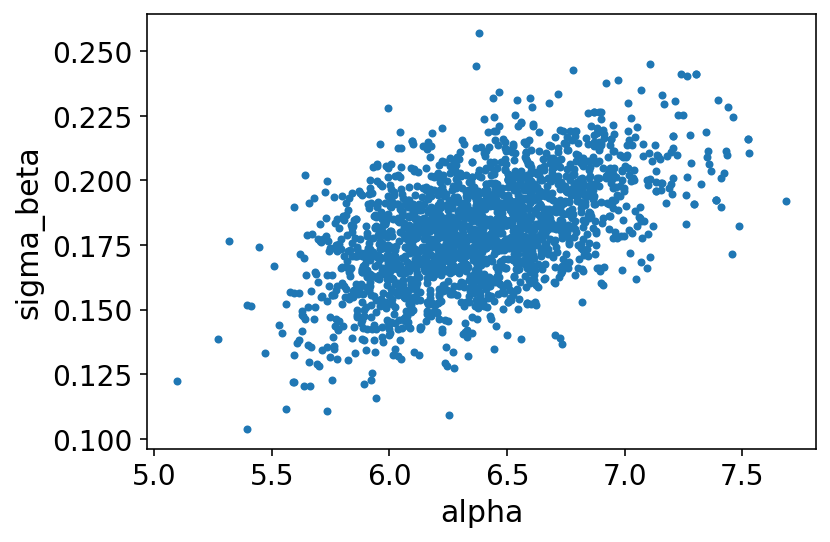

In [30]:
ax = az.plot_pair(sp9_mcmc, var_names=["alpha", "sigma_beta"], divergences=True)
# ax.set_yscale("log")
plt.show()

In [31]:
ax = az.plot_pair(sp9_mcmc, var_names=["sigma_mu_beta", "sigma_beta"], divergences=True)
# ax.set_yscale("log")
plt.show()

KeyError: 'var names: "[\'sigma_mu_beta\'] are not present" in dataset'

In [ ]:
def scale_pair_plot_yaxis(axes: np.ndarray) -> None:
    for ax in axes.flatten():
        ax.set_yscale("log")
    return None

In [ ]:
data.hugo_symbol.cat.categories[71], data.depmap_id.cat.categories[5]

('HYI', 'ACH-001526')

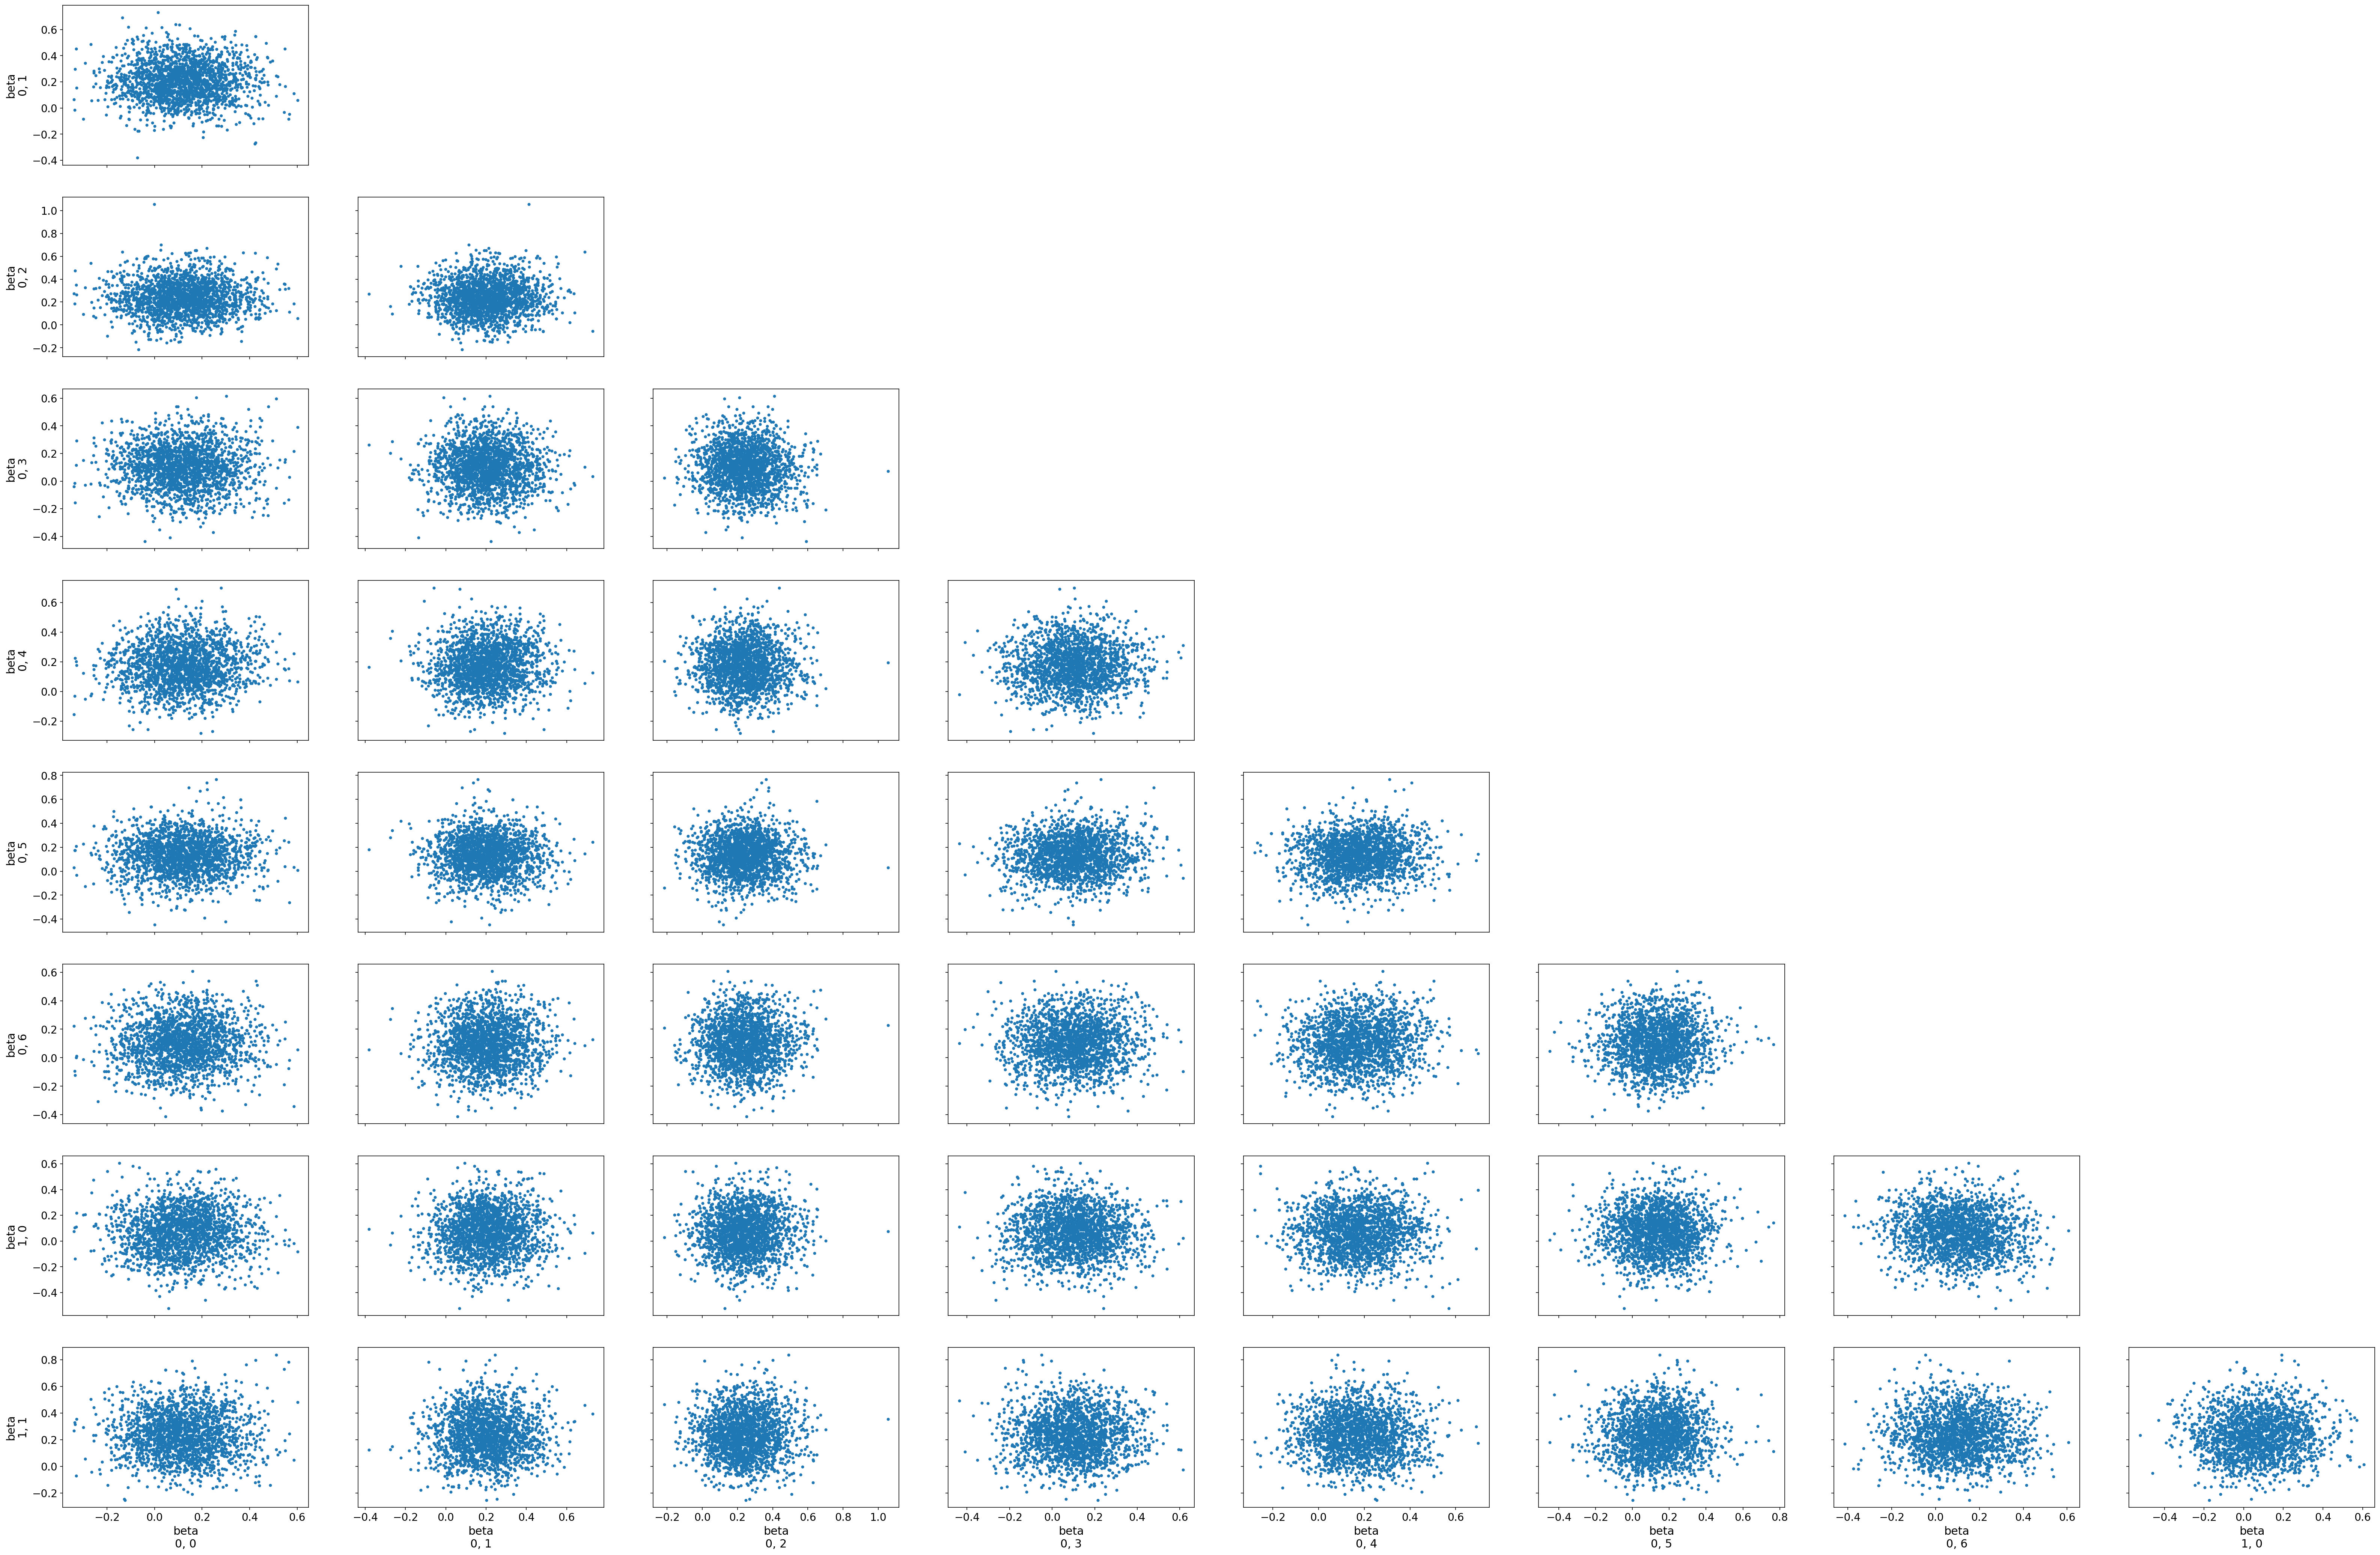

In [32]:
axes = az.plot_pair(
    sp9_mcmc,
    var_names=["beta", "sigma_beta"],
    coords={"gene": "TP53", "cell_line": "ACH-001283"},
    divergences=True,
)
ax.set_yscale("log")
plt.show()

In [34]:
beta_post = (
    az.summary(sp9_mcmc, var_names="beta", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "model_param"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="model_param",
        idx1=data.hugo_symbol.cat.categories,
        idx2=data.depmap_id.cat.categories,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)
beta_post.head()

model_param   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0   beta[0,0]  0.119  0.147    -0.125      0.344      0.003    0.003   
1   beta[0,1]  0.205  0.140    -0.015      0.433      0.003    0.002   
2   beta[0,2]  0.239  0.141    -0.003      0.445      0.003    0.002   
3   beta[0,3]  0.102  0.152    -0.132      0.357      0.003    0.003   
4   beta[0,4]  0.174  0.142    -0.054      0.403      0.003    0.003   

   ess_bulk  ess_tail  r_hat hugo_symbol   depmap_id  
0    2170.0    1185.0   1.01     TMPRSS3  ACH-001345  
1    2854.0    1404.0   1.01     TMPRSS3  ACH-000087  
2    2188.0    1085.0   1.00     TMPRSS3  ACH-001526  
3    2550.0    1159.0   1.00     TMPRSS3  ACH-000007  
4    2297.0    1249.0   1.00     TMPRSS3  ACH-001283

In [ ]:
mu_beta_post = (
    az.summary(sp9_mcmc, var_names="mu_beta", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "model_param"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="model_param",
        idx1=data.hugo_symbol.cat.categories,
        idx2=data.lineage.cat.categories,
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)
mu_beta_post.head()

IndexError: index 1 is out of bounds for axis 1 with size 1

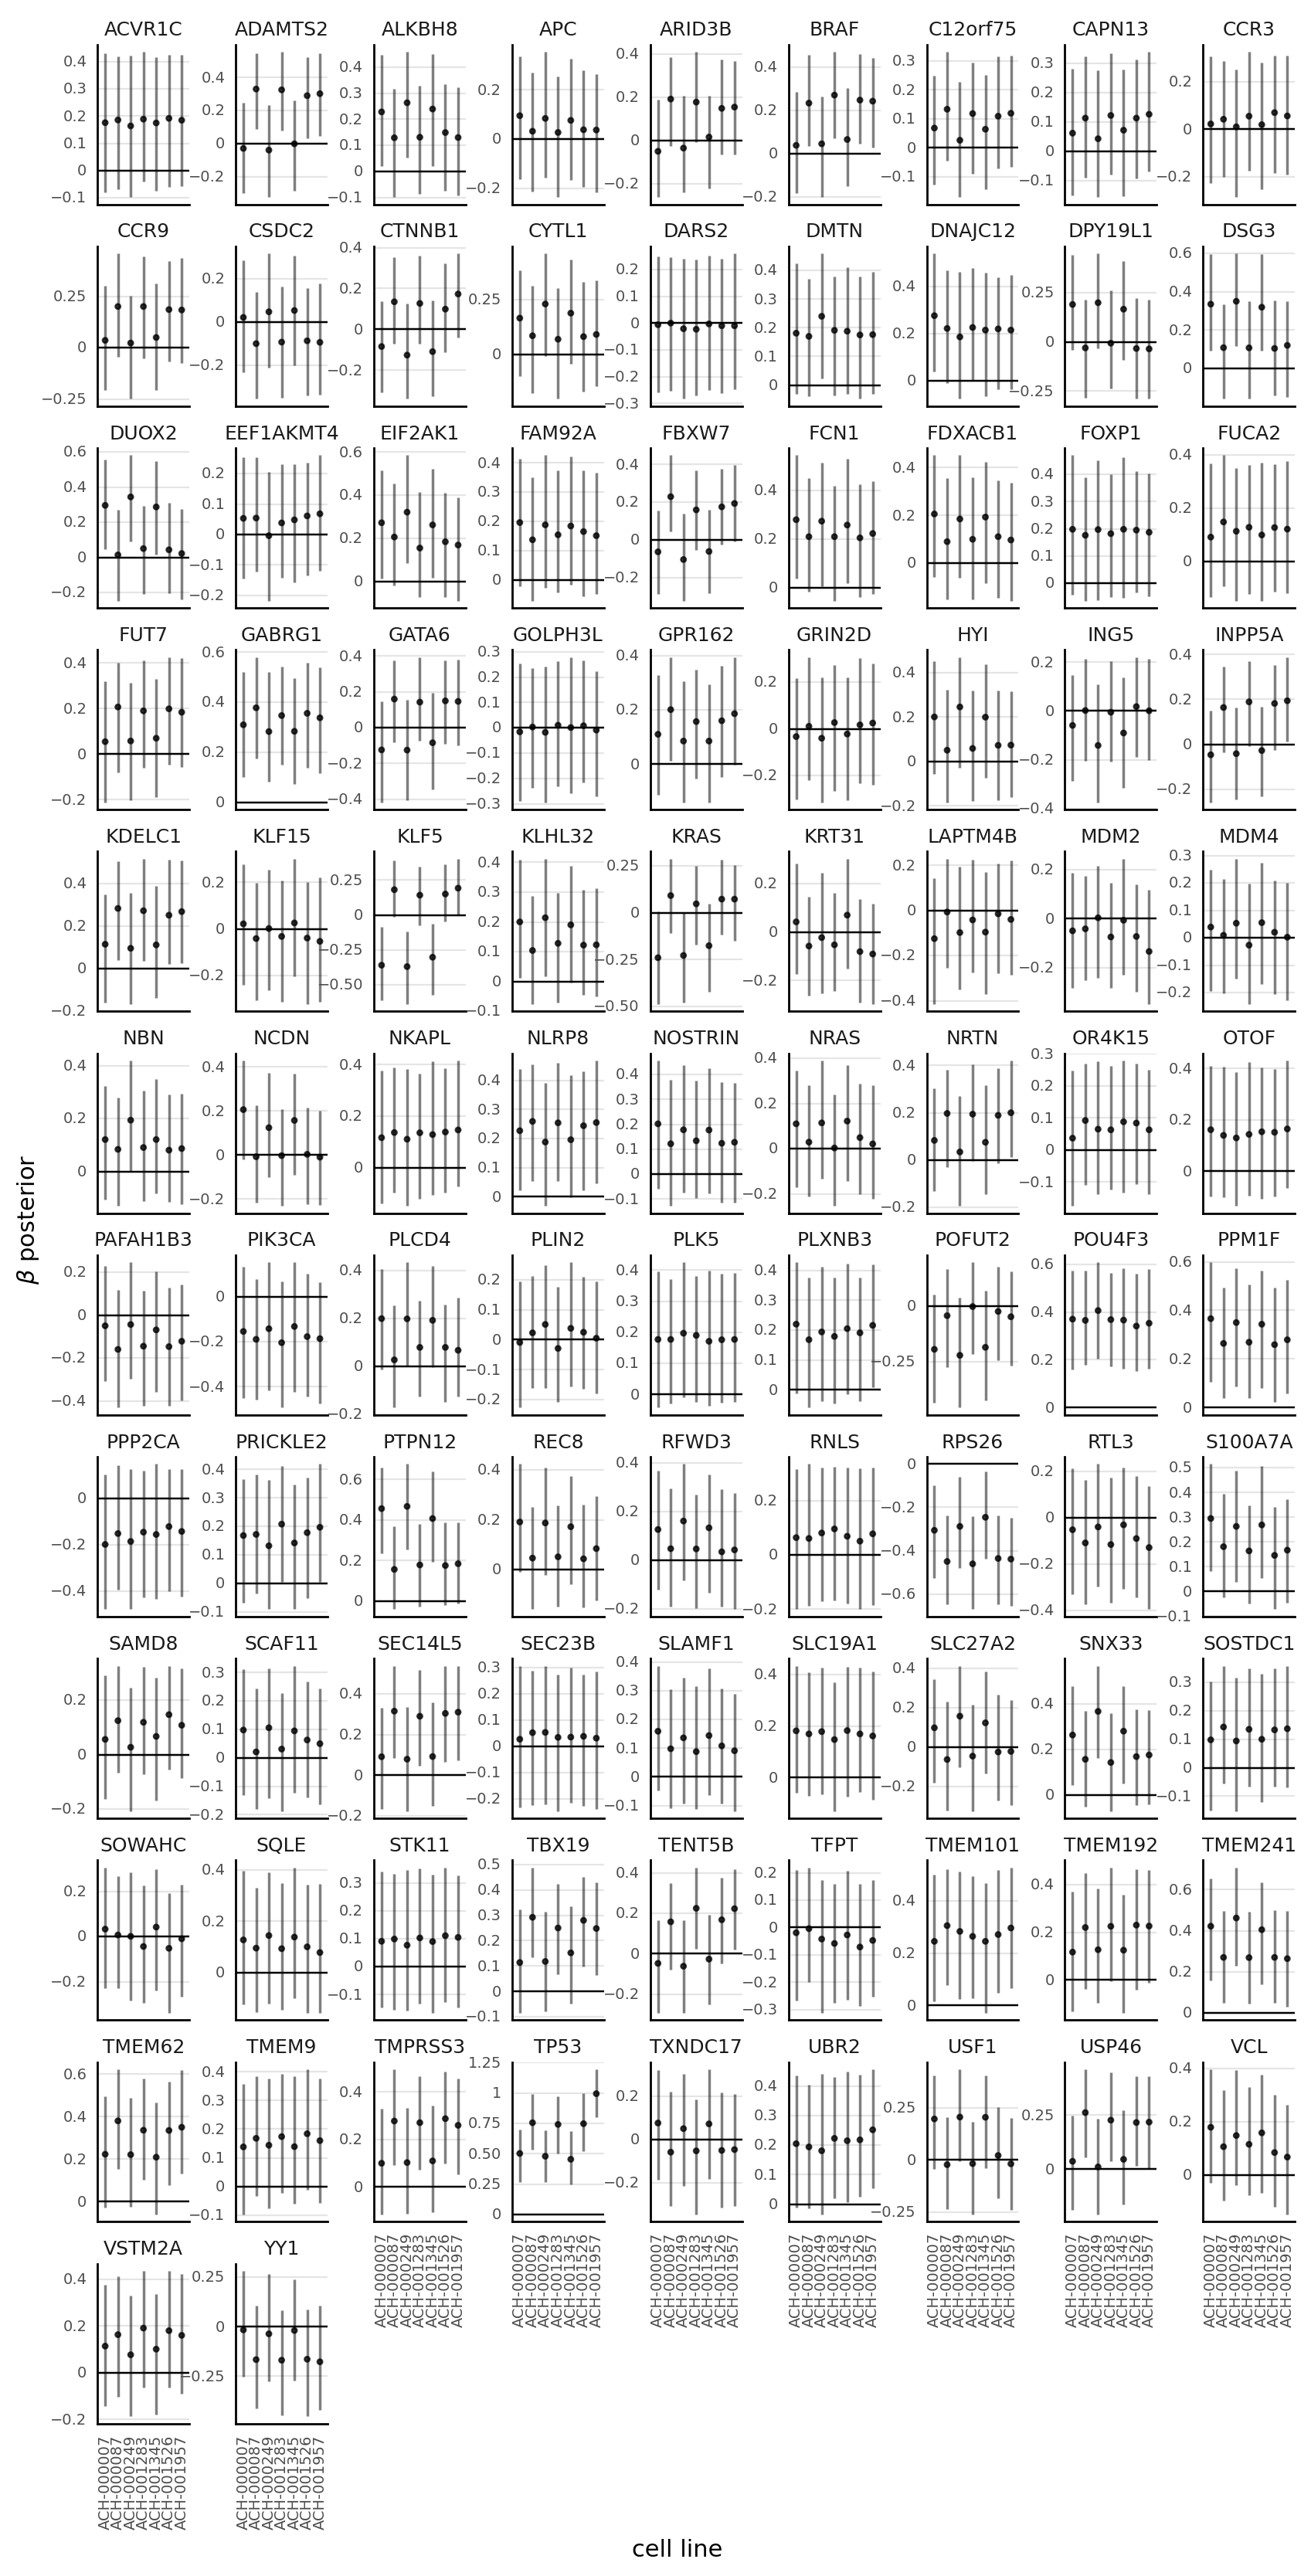

<ggplot: (361425806)>

In [ ]:
(
    gg.ggplot(beta_post, gg.aes(x="depmap_id", y="mean"))
    + gg.facet_wrap("hugo_symbol", ncol=9, scales="free_y")
    + gg.geom_hline(yintercept=0, data=mu_beta_post, color="black", inherit_aes=False)
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.7, alpha=0.5)
    + gg.geom_point(size=0.8, alpha=0.75)
    + gg.theme(
        figure_size=(10, 20),
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_text_y=gg.element_text(size=7),
        panel_grid_major_y=gg.element_line(),
        panel_spacing_x=0.3,
        strip_text=gg.element_text(size=9),
    )
    + gg.labs(x="cell line", y="$\\beta$ posterior")
)

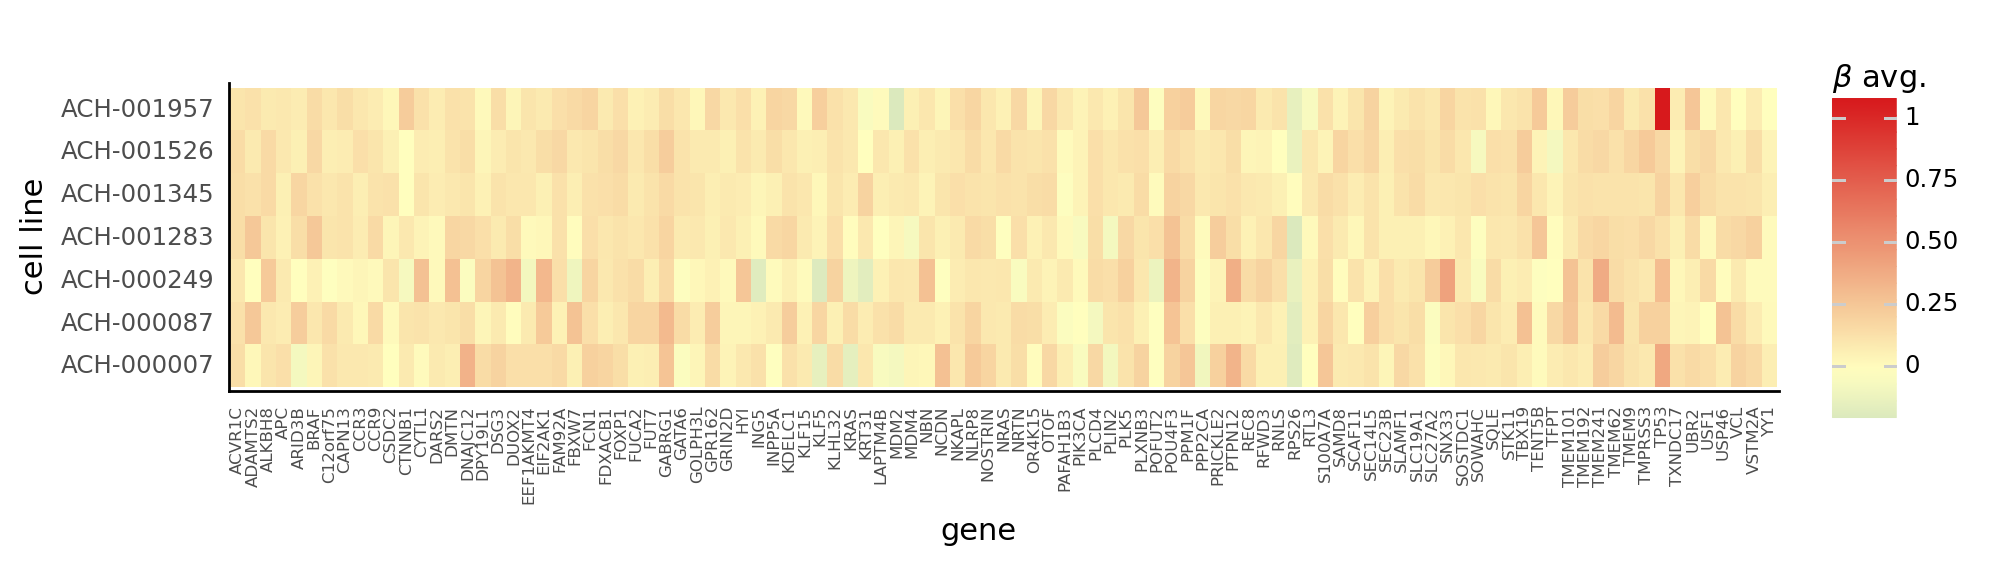

<ggplot: (368451943)>

In [35]:
(
    gg.ggplot(beta_post, gg.aes(x="hugo_symbol", y="depmap_id", fill="mean"))
    + gg.geom_tile()
    + gg.scale_fill_gradient2(high="#d7191c", low="#2c7bb6", mid="#ffffbf", middle=0)
    + gg.theme(axis_text_x=gg.element_text(size=6, angle=90), figure_size=(10, 2))
    + gg.labs(x="gene", y="cell line", fill="$\\beta$ avg.")
)

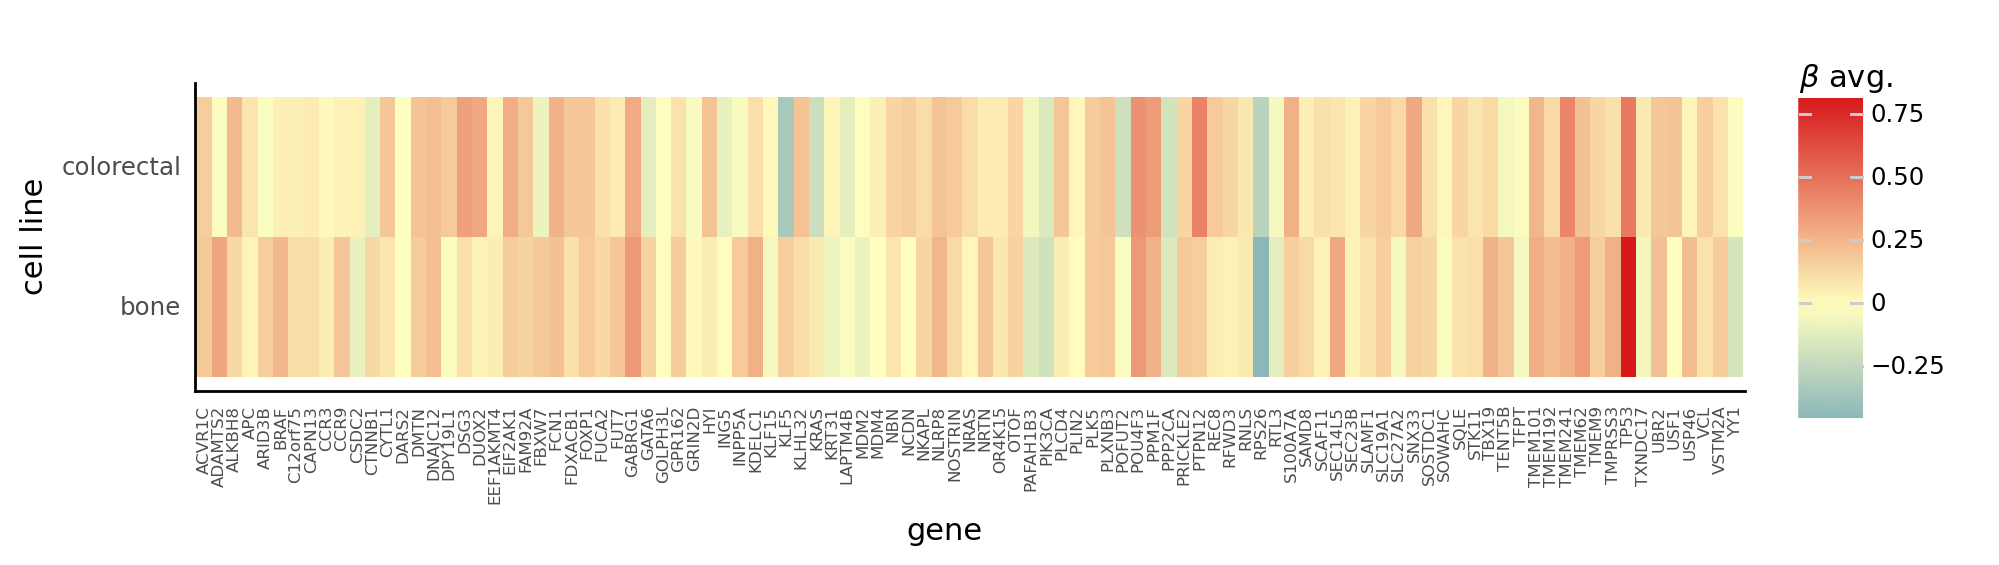

<ggplot: (367976186)>

In [ ]:
(
    gg.ggplot(mu_beta_post, gg.aes(x="hugo_symbol", y="lineage", fill="mean"))
    + gg.geom_tile()
    + gg.scale_fill_gradient2(high="#d7191c", low="#2c7bb6", mid="#ffffbf", middle=0)
    + gg.theme(axis_text_x=gg.element_text(size=6, angle=90), figure_size=(10, 2))
    + gg.labs(x="gene", y="cell line", fill="$\\beta$ avg.")
)

<AxesSubplot:xlabel='y'>

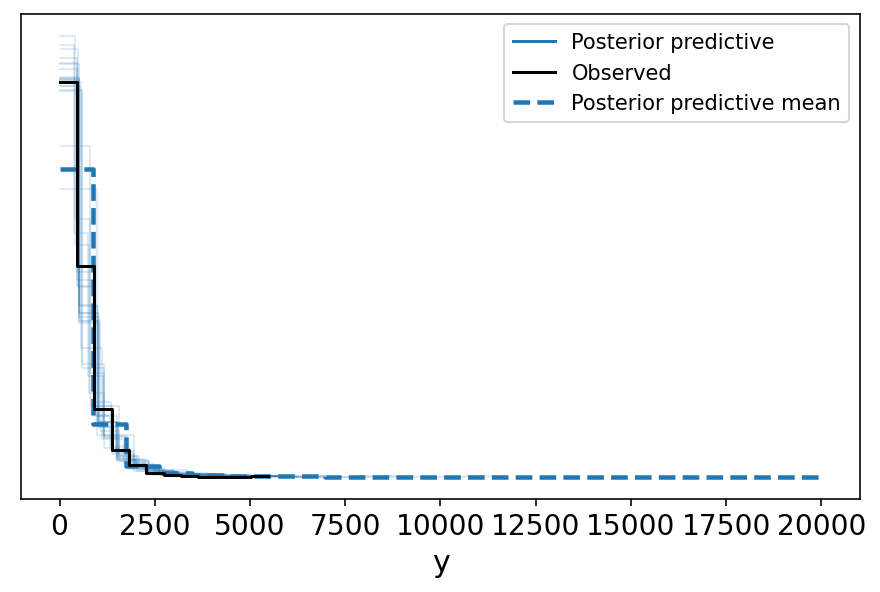

In [27]:
az.plot_ppc(sp9_mcmc, num_pp_samples=20, random_seed=1234)

In [28]:
sp9_ppc = sp9_mcmc.posterior_predictive["y"].values.squeeze()
post_pred_data = data.copy().assign(post_pred=sp9_ppc.mean(axis=0))

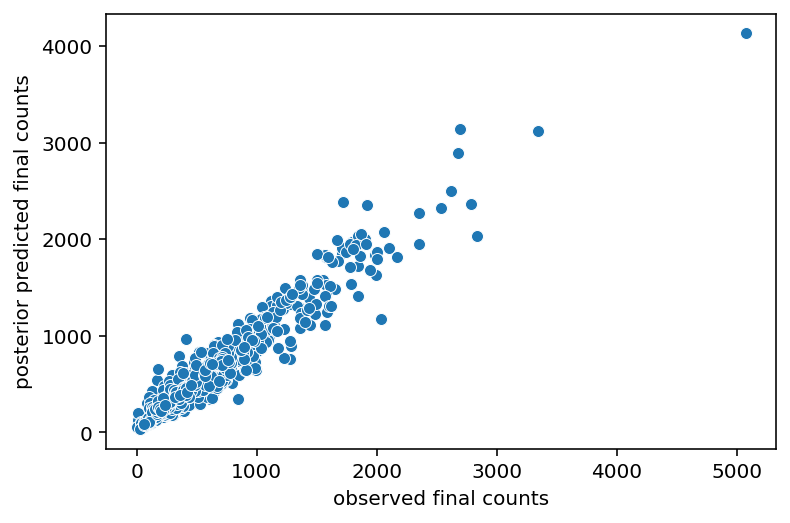

In [29]:
ax = sns.scatterplot(data=post_pred_data, x="counts_final", y="post_pred")
ax.set_xlabel("observed final counts")
ax.set_ylabel("posterior predicted final counts")
plt.show()

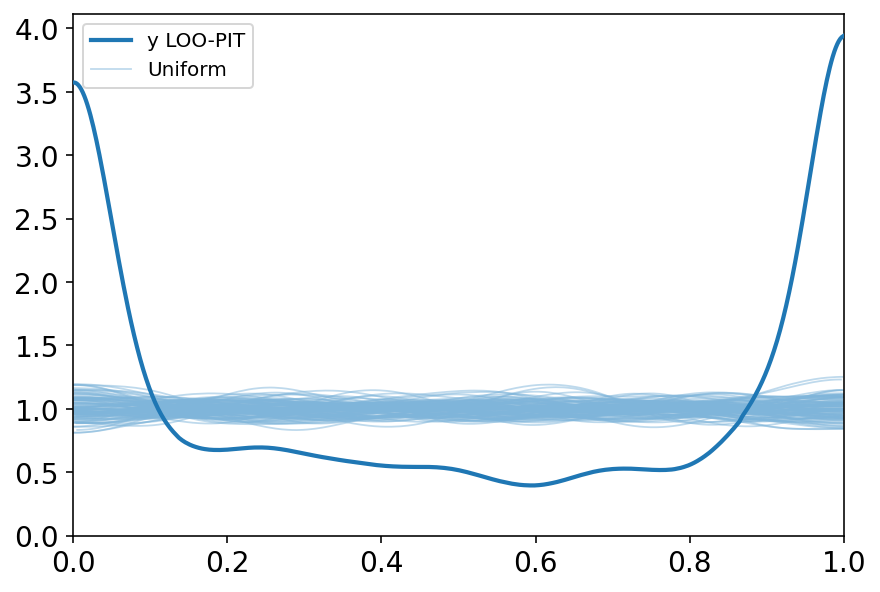

In [30]:
az.plot_loo_pit(sp9_mcmc, y="y")
plt.show()

In [31]:
sp9_loo_pit = az.loo_pit(sp9_mcmc, y="y")

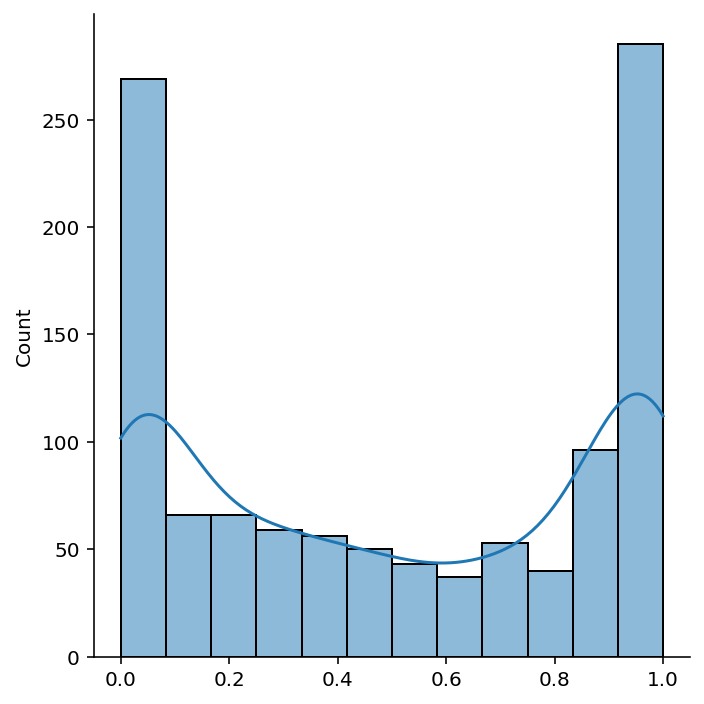

In [32]:
sns.displot(sp9_loo_pit, kind="hist", kde=True)
plt.show()

In [33]:
sp9_loo = az.loo(sp9_mcmc, pointwise=True, var_name="y")

In [34]:
post_pred_data["loo"] = sp9_loo.loo
post_pred_data["pareto_k"] = sp9_loo.pareto_k

In [35]:
(
    gg.ggplot(post_pred_data.reset_index(), gg.aes(x="index", y="pareto_k"))
    + gg.geom_point(size=0.8, alpha=0.8)
    + gg.geom_text(
        gg.aes(label="hugo_symbol"),
        post_pred_data.reset_index().query("pareto_k >= 0.7"),
        color="blue",
        size=5,
        adjust_text={"color": "blue"},
    )
    + gg.scale_x_continuous(expand=(0, 1))
    + gg.scale_y_continuous(expand=(0.04, 0))
    + gg.theme(axis_text_x=gg.element_blank(), figure_size=(6, 4))
)

KeyboardInterrupt: 

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.68 minutes


In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-11-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: sp9

pandas    : 1.3.2
janitor   : 0.21.0
seaborn   : 0.11.2
logging   : 0.5.1.2
matplotlib: 3.4.3
arviz     : 0.11.2
sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
pymc3     : 3.11.2
plotnine  : 0.8.0
numpy     : 1.21.2

